In [28]:
import numpy as np
import imageio.v3 as iio
import skimage as ski
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import disk, opening, skeletonize

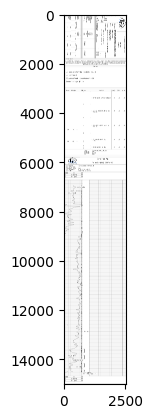

In [ ]:
# Load the whole image
O = iio.imread(uri="../T14502Las/T14502_02-Feb-07_JewelryLog.tiff")
# Convert to grayscale
#O = ski.color.rgb2gray(O)
# Display the image
plt.imshow(O)
plt.show()


y: 15012, x: 2550


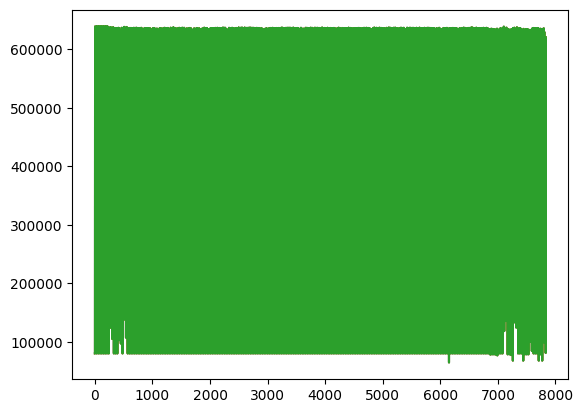

In [30]:
y, x = O.shape[:2]
print(f"y: {y}, x: {x}")
#Read each line of image until the whole line value = white, then remove all lines with that value and all prior
def horizontal_projection(line_pixels):
    return np.sum(line_pixels, axis=1) # Do the same but for other axis when segmenting graphs

tmp = horizontal_projection (O[6737:14570])

plt.plot(tmp)


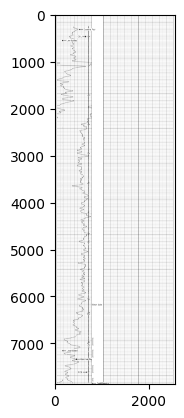

In [31]:
plt.imshow(O[6700:14570])

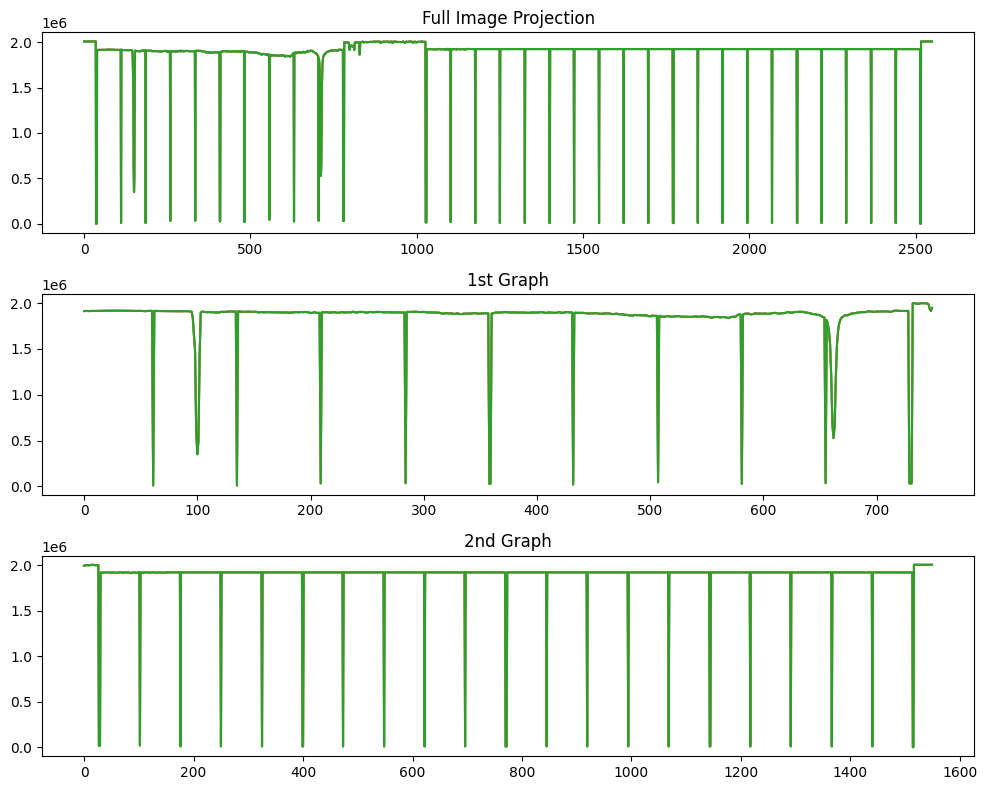

In [32]:
# Looking at the other axis to recognize the different graphs

# Save the interval without the headers
headerless_O = O[6700:14570]

def horizontal_projection(line_pixels):
    return np.sum(line_pixels, axis=0)

tmp = horizontal_projection(headerless_O)

#plt.plot(tmp)

O_graph1 = horizontal_projection(headerless_O[:, 50:800]) 
#plt.plot(O_graph1_x)

O_graph2 = horizontal_projection(headerless_O[:, 1000:]) 

# Create three separate subplots
plt.figure(figsize=(10, 8))  # Optional: specify figure size

# First subplot
plt.subplot(3, 1, 1)
plt.plot(tmp)
plt.title('Full Image Projection')

# Second subplot
plt.subplot(3, 1, 2)
plt.plot(O_graph1)
plt.title('1st Graph')

# Thirs subplot
plt.subplot(3, 1, 3)
plt.plot(O_graph2)
plt.title('2nd Graph')

# Add some spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

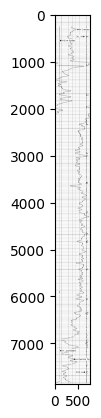

In [33]:
# 1st graph, with the curve
plt.imshow(headerless_O[:, 50:800])
#iio.imwrite("testfolder/fulltext.tif",headerless_O[:, 50:800])

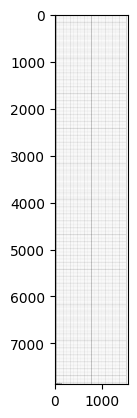

In [34]:
# 2nd graph with nothing on it, really
plt.imshow(headerless_O[:, 1000:])


In [35]:
# Cutting the graph into smaller chunks to work on
grahp1 = headerless_O[:, 50:800]

#grahp1 = iio.imread("Removetextfromkurve/Textremoved.tiff")
def chunkify(p_pic):
    threshold = 600
    chunks = []
    
    def split(p_pic):
        if p_pic.shape[0] <= threshold:
            chunks.append(p_pic)
        else:
            half = p_pic.shape[0] // 2
            split(p_pic[:half])
            split(p_pic[half:])
    
    split(p_pic)
    return chunks

graph_chunks = chunkify(grahp1)
for i in graph_chunks:
    print(i.shape)



(491, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(491, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)
(492, 750, 3)


ValueError: operands could not be broadcast together with shapes (1,750,3) (0,) 

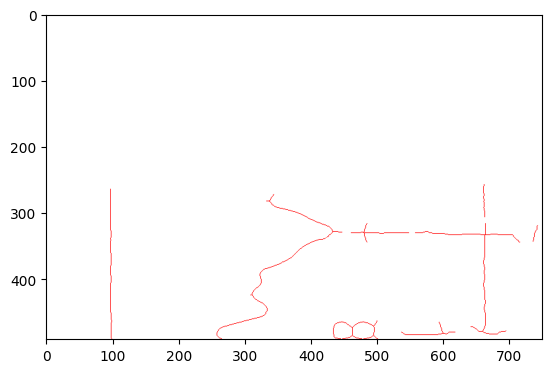

In [36]:
def process_chunks(chunk):
    array = []
    for i in chunk:
        overlays = []
        # Grayscale
        #print(f'i.shape: \n {i.shape[2]}')
        I_gray = ski.color.rgb2gray(i)
        #print(f'i gray.shape: \n {I_gray.shape}')
        I_grayg = ndimage.gaussian_filter(I_gray, sigma=1)
        # Attempt with OTSU's method
        threshold = ski.filters.threshold_otsu(I_grayg)
        mask = (I_grayg > threshold)
        min_pixels = 200
        row_mask = np.sum(mask, axis=1) < min_pixels
        col_mask = np.sum(mask, axis=0) < min_pixels
        #print(f'row mask: \n {row_mask}')
        # Add a new axis and add the maskings to that as well with np.repeat
        mask_combined = np.repeat((row_mask[:, np.newaxis] | col_mask[np.newaxis, :])[:, :, np.newaxis], i.shape[2], axis=2)
        #print(f'mask combined: \n {mask_combined}')
        K = np.maximum(i, np.max(i) * mask_combined)
        se = disk(10)
        J = opening(K.mean(axis=2), se)
        S = skeletonize(J<128)
        #plt.figure(figsize=(10,10))
        #plt.subplot(2, 2, 4)
        overlay = np.zeros(i.shape[:2] + (3,), dtype=np.uint8) + 255
        overlay[S] = [255, 0, 0]
        #plt.imshow(overlay)
        #plt.imshow(i, cmap="gray", alpha=0.2)
        #plt.axis("image")
        overlays.append(overlay)
        if array == []:
            array = overlay[:1]
        else:
            array = np.concatenate((array.shape[:1],overlay.shape[:1]),axis=0)
        
        plt.imshow(overlay)
        #plt.imshow(i, cmap="gray", alpha=0.2)
        plt.axis("image")
    temparray = np.rot90(array)
    fig, ax = plt.subplots()
    ax.imshow(temparray)
    print("plot 1:")
    temp2array = np.concatenate((temparray,temparray),axis=0)
    fig, ax = plt.subplots()
    ax.imshow(temp2array)
    print("plot 2:")
    #iio.imwrite("testfolder/overlaytest0.tif",temparray)
        
    return overlays


temp = process_chunks(graph_chunks)
#iio.imwrite("Removetextfromkurve/overlay.tiff", temp)

ValueError: operands could not be broadcast together with shapes (491,750,3) (0,) 

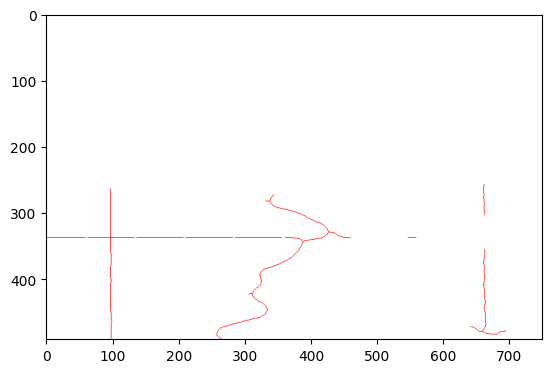

In [ ]:
""" test = process_chunks(graph_chunks)
plt.imshow(test[0][0:]) """